TASK #3 - A total of 40 objects were kept for further analysis
querying sdss database for all objects, sleeping for 1 second after each query, be patient...
finished sdss query
TASK #5 - SDSS query found magnitudes for 39 of the 40 objects


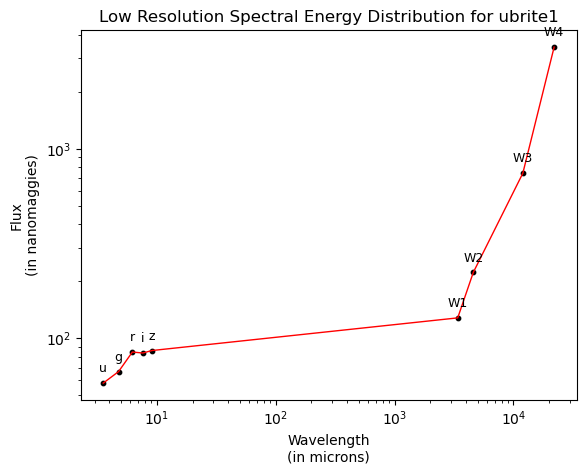

TASK #10 -
	This object is classified as a STAR, but is at redshift of 1.03, which is not in our galaxy. It's spectrum is labeled as a QSO 
    which makes much more sense. This object was selected because it has a large flux in the u-band, and its W2 flux is significantly
    larger than its W1 flux (this comes from the constraint that W1-W2 > 0.5, which traces hot dust emission). Coupled with the fact that
    we masked out all objects with low r_band emission, it is not surprising that this optically bright object that is surrounded 
    by hot dust happens to be an extragalactic QSO



Script finished in 102.59 seconds

After re-running this script from scracth a bunch of times, the median time (in seconds) was 73, with a mean of 146 
and a standard deviation of 115. Note that this distribution is heavilly skewed to longer wavelengths and no trial took LESS than 70 seconds


In [1]:
import time
start = time.time()#TJ get exact start time (for computing total execution time)
from astropy.table import Table, vstack, Column, Row
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import argparse

def read_partial_fits(filepath, kept_column_names):
    '''read in table and only save necessary columns this saves memory and time with further manipulations compared to saving EVERY column
    -------------

    Parameters
    -------------
    filepath :  type = str - string representing path to .fits files you want to read in
    kept_column_names :  type = list - list of strings corresponding to which columns need to be read in. All other columns are ignored
    
    Returns
    -------------
    table with only the columns that we wanted to keep
    '''
    
    with fits.open(filepath) as hdul:
        data = hdul[1].data  #TJ read in all data
        filtered_data = {col: data[col] for col in kept_column_names} #TJ filter data to only keep necessary columns
        return Table(filtered_data)



def add_mag_column(original_table, fluxes):
    '''Add one new column in table for every column with name in fluxes (example: FLUX_x). New column will be named "x_mag".
    *Assumes fluxes are given in nanomaggy
    -------------

    Parameters
    -------------
    table :  type = astropy.table - table with at least one column name in "fluxes"
    fluxes : type = list - list of strings corresponding to which columns of fluxes you want to add a corresponding magnitude column

    Returns
    -------------
    Original table, with new columns for magnitudes
    '''

    for flux_col in fluxes:
        band = flux_col.split('_')[1] #TJ extract column name, "FLUX_R" will have the "R" pulled out and used to name new column "R_mag"
        new_col_name = f"{band}_mag"  #TJ define new column e.g., 'G_mag' for original "FLUX_G"

        original_table[new_col_name] = 22.5 - 2.5*np.log10(original_table[flux_col]) #TJ convert flux to magnitude
    return original_table





def cross_match(match_all_these, find_matches_from_here, max_sep=1/3600):
    '''find objects in the find_matches_from_here table that are the closest RA,DEC from the objects in the match_all_these table

    -------------

    Parameters
    -------------
    match_all_these :  type = astropy.table - table with columns for "RA" and "DEC"
    find_matches_from_here :  type = astropy.table - table with columns for "RA" and "DEC"
    max_sep (optional, defaults to 1/3600) : type = float - fail to match objects if no object is closer than this many degrees away from it                  
    
    Returns
    -------------
    Table with only rows selected from the match_all_these table that found matches in the find_matches_from_here table
    Table from the find_matches_from_here table that are the valid matches to entries in the match_all_these table
    '''
    #TJ create skycoord object for all objects in survey table, convert to cartesian for accurate ckd searching
    #TJ ckdtree uses euclidiean distance formula, so leaving it in ra and dec would distort near poles
    survey_coords = SkyCoord(find_matches_from_here['RA'], find_matches_from_here['DEC'], unit=u.deg)
    survey_xyz = np.vstack(survey_coords.cartesian.xyz).T 

    #TJ create skycoord object for all objects in observation table, convert to cartesian to remove dimensional distortion for cdk tree structuring
    obs_coords = SkyCoord(match_all_these['RA'], match_all_these['DEC'], unit=u.deg)
    obs_xyz = np.vstack(obs_coords.cartesian.xyz).T
    tree = cKDTree(survey_xyz) #TJ build ckd tree for efficient searching

    #TJ query the tree for the nearest neighbor of each object in match_all_these table
    _, matched_indices = tree.query(obs_xyz) #TJ first output is the matched entry's euclidean distance from source, not easy to convert to deg
    
    separations = obs_coords.separation(survey_coords[matched_indices]).deg  #TJ calculate separation from each "closest match" object

    #TJ apply filters requested in HW3 prompts
    valid_matches = (separations < max_sep) & \
                    (find_matches_from_here['R_mag'][matched_indices] <= 22) & \
                    ((find_matches_from_here['W1_mag'][matched_indices] - find_matches_from_here['W2_mag'][matched_indices]) > 0.5)

    #TJ extract the objects that satisfy all the above constraints, return BOTH tables' filtered rows
    filtered_match_all_these = match_all_these[valid_matches]
    filtered_matches_table = find_matches_from_here[matched_indices[valid_matches]]


    return filtered_match_all_these, filtered_matches_table


def add_sdss_u_and_i_mag_columns(table, sdss_path='/d/scratch/ASTR5160/week8/sdssDR9query.py'):
    '''takes a table with columns for "RA" and "DEC", and adds new columns for u_mag and i_mag, filled with data from sdss database

    *NOTE* This function uses a slow process for querying objects, it is generally recomended to use sdss_query() function from
    random_functions.py, as that one will query the first 60 objects as quickly as possible, and will always query the full maximum of 
    60 objects per minute. This function sleeps for 1 second every query and therefore takes longer than 1 minute to query 60 objects.
    -------------

    Reequires access to 'sdssDR9query.py' via path given as optional argument
    -------------

    Parameters
    -------------
    table :  type = astropy.table - table with columns for "RA" and "DEC", case-sensitive
    sdss_path (optional, defaults to '/d/scratch/ASTR5160/week8/sdssDR9query.py') : type = str - path to sdss_query script

    
    Returns
    -------------
    original table, now with columns for u_mag and i_mag (value will be nan if no object was found in sdss query (tolerance of 1.2")
    '''
    
    #TJ add columns for SDSS query results
    table.add_column(Column(name='u_mag', data=np.nan * len(table)))
    table.add_column(Column(name='i_mag', data=np.nan * len(table)))
    print('querying sdss database for all objects, sleeping for 1 second after each query, be patient...')
    for row in table:
        ra, dec = row['RA'], row['DEC'] #TJ assign ra and dec values for query
        
        #TJ run the required sdss script and capture the output as a text string, strip off any extraneous white spaces
        output = subprocess.check_output(
            ['python', f'{sdss_path}', f'{ra}', f'{dec}'], #TJ runs the script as a subprocess
            text=True  #TJ makes output a string, rather than bytes
        ).strip()  #TJ strips off any leading/trailing whitespace
        if output == 'No objects have been found': #TJ use my ONE extra if statement to leave value as nan if there are no objects found
            continue
        else:
            row["u_mag"], row["i_mag"] = float(output.split(',')[2]), float(output.split(',')[5]) #TJ grab the u and i mag values from the output
    print(f"finished sdss query")
    return table



if __name__ == "__main__":
    '''parser = argparse.ArgumentParser(description="""No arguments accepted at command line. Searches 'FIRST' data for objects within 3 degrees 
    of ra, dec = (163, 50). Cross matches these objects to objects in the legacy north sweep surveys that have W1-W2 colors of > 0.5 AND 
    r_magnitudes of < 22, then records their g, r, z, and WISE 1-4 nanomaggy flux values and magnitudes. Queries the SDSS database to get 
    their u and i magnitudes and converts to nanomaggy fluxes. Finds the object in this dataset that is brightest in the u_band and plots
    these nine flux values as a function of wavelength. Prints brief comment about results.""") #TJ add argparse informative help statement
    #TJ apparently you need to add at least one argument (even if its useless) to make --help command visible?
    parser.add_argument('--dummy', help=argparse.SUPPRESS)  #TJ completely useless, hidden dummy argument
    args = parser.parse_args()'''

    #TJ define filepath to FIRST dataset
    FIRST_filepath = '/d/scratch/ASTR5160/data/first/first_08jul16.fits'
    FIRST_data = read_partial_fits(FIRST_filepath, ["RA", "DEC"]) #TJ we only need ra and dec from this table.
    center_of_field = SkyCoord(163, 50, unit = u.deg) #TJ Define center of field, only objects within 3 degrees of this will be kept
    all_obj_loc = SkyCoord(FIRST_data["RA"], FIRST_data["DEC"], unit = u.deg) #TJ create skycoord object for every object in the FIRST file
    
    in_survey = FIRST_data[all_obj_loc.separation(center_of_field).deg < 3] #TJ extract only objects from the FIRST file that are within 3 degrees
    #TJ this can also be done with a search_around_sky(), but for some reason takes longer? idk this timing is inconsistent
    #TJ in_survey now is a table of only FIRST objects within the astronomer's survey
    
    sweep_directory = '/d/scratch/ASTR5160/data/legacysurvey/dr9/north/sweep/9.0/' #TJ assign necessary sweep file directory
    #TJ assign needed sweep file paths
    sweep_files = [sweep_directory + 'sweep-150p045-160p050.fits', 
                   sweep_directory + 'sweep-160p045-170p050.fits', 
                   sweep_directory + 'sweep-150p050-160p055.fits', 
                   sweep_directory + 'sweep-160p050-170p055.fits'] 
    #TJ only save data in columns we actually need, this table has WAYYYY too many columns and it slows down computation time to perform
    #TJ manipulations on the entire table.
    sweep_columns_to_keep = ['RA', 'DEC', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4']
    
    sweep_data = vstack([read_partial_fits(file, sweep_columns_to_keep) for file in sweep_files]) #TJ stack all the sweep data underneath the last one
    for flux_col in ['FLUX_W1', 'FLUX_W2', 'FLUX_R']: #TJ prevent attempting to take log10 of negative number by replacing with a small positive number
        #TJ not sure if this is actually faster than an if statement, but its definitely harder to read
        sweep_data[flux_col] = np.where(sweep_data[flux_col] <= 0, 1e-10, sweep_data[flux_col]) #TJ is this technically an "if-else statement"?
    sweep_data = add_mag_column(sweep_data, ["FLUX_R", "FLUX_W1", "FLUX_W2"]) #TJ add magnitude columns for r, W1, and W2

    rel_FIRST_data, rel_sweep_data = cross_match(in_survey, sweep_data) #TJ perform cross match using cdk tree matching
    #TJ these tables are now only the relevent objects that will be used for further analysis

    print(f"TASK #3 - A total of {len(rel_FIRST_data)} objects were kept for further analysis") #TJ print total objects that are kept
    rel_sweep_data = add_sdss_u_and_i_mag_columns(rel_sweep_data) #TJ query sdss database for each of these objects

    nan_count = np.sum(np.isnan(rel_sweep_data['u_mag'])) #TJ count how many nan values are in the set
    #TJ the total length, minus number of nans is the number of successful queries from SDSS
    
    print(f'TASK #5 - SDSS query found magnitudes for {len(rel_sweep_data) - nan_count} of the {len(rel_sweep_data)} objects')
    
    #TJ I think there is a typo in the assignment and this is actually asking which of these cross-matched objects is the brightest.
    #TJ I ran a much more time consuming analysis on all 2637 FIRST objects that are in the astronomer's survey, and it returned
    #TJ an object brighter in the u_band. The brightest object is actually sweep_data[2040637] which has a u_mag of 15.07173
    #TJ but this object has a W1-W2 color of -0.10889053 which did not meet the minimum value of 0.5 to be selected.
    
    nan_mask = ~np.isnan(rel_sweep_data["u_mag"]) #TJ mask out the nan(s) in the table so they dont get selected as the lowest value
    global_idx = np.where(nan_mask)[0][np.argmin(rel_sweep_data["u_mag"][nan_mask])] #TJ find the index in the full table that has the lowest u_mag
    
    ubrite1 = {col: rel_sweep_data[col][global_idx] for col in rel_sweep_data.colnames} #TJ create a dictionary that is JUST ubrite1
    #TJ I couldnt find a nice way to make a table that is just one row from this table

    ubrite1['FLUX_U'] = 10 ** ( -(ubrite1["u_mag"]-22.5)/2.5) #TJ add flux values for u and i bands, sdss query only gave magnitudes
    ubrite1['FLUX_I'] = 10 ** ( -(ubrite1["i_mag"]-22.5)/2.5)

    #TJ define x,y positions for plotting flux vs wavelength
    positions = [[3.543, ubrite1["FLUX_U"]],
                 [4.77, ubrite1["FLUX_G"]], 
                 [6.231, ubrite1["FLUX_R"]], 
                 [7.625, ubrite1["FLUX_I"]], 
                 [9.134, ubrite1["FLUX_Z"]], 
                 [3400, ubrite1["FLUX_W1"]], 
                 [4600, ubrite1["FLUX_W2"]], 
                 [12000, ubrite1["FLUX_W3"]],
                 [22000, ubrite1["FLUX_W4"]]]                                 
    band_labels = ['u', 'g', 'r', 'i', 'z', 'W1', 'W2', 'W3', 'W4'] #TJ these will be the labels for the datapoints on the graph
    wavelengths = np.array([p[0] for p in positions]) #TJ pick out wavelengths and fluxes
    fluxes = np.array([p[1] for p in positions])
    
    plt.plot(wavelengths, fluxes, '-', color='red', linewidth=1) #TJ plot a line connecting each flux measurement
    plt.scatter(wavelengths, fluxes, s=10, color='black') #TJ put dots on the actual data points
    for w, f, label in zip(wavelengths, fluxes, band_labels):
        plt.text(w, f*1.1, label, ha='center', va='bottom', fontsize=9) #TJ label all the dots with their respective band labels
    plt.xscale('log') #TJ change x-axis to log space so the ugriz arent on top of each other
    plt.yscale('log') #TJ change y-axis to log space so the ugriz arent all just at basically zero compared to WISE bands
    plt.xlabel('Wavelength\n(in microns)')
    plt.ylabel('Flux\n(in nanomaggies)')
    plt.title('Low Resolution Spectral Energy Distribution for ubrite1')
    plt.show()    
    print('TASK #10 -')
    print('''\tThis object is classified as a STAR, but is at redshift of 1.03, which is not in our galaxy. It's spectrum is labeled as a QSO 
    which makes much more sense. This object was selected because it has a large flux in the u-band, and its W2 flux is significantly
    larger than its W1 flux (this comes from the constraint that W1-W2 > 0.5, which traces hot dust emission). Coupled with the fact that
    we masked out all objects with low r_band emission, it is not surprising that this optically bright object that is surrounded 
    by hot dust happens to be an extragalactic QSO''')
    
    #TJ print total time for script for execution
    print() #TJ adding lines to separate printed statements
    print()
    print()
    print(f"Script finished in {time.time() - start:.2f} seconds")
    print()
    print('After re-running this script from scracth a bunch of times, the median time (in seconds) was 73, with a mean of 146 \nand a standard deviation of 115. Note that this distribution is heavilly skewed to longer wavelengths and no trial took LESS than 70 seconds')